In [51]:
# The following is necessary to run the cells that follow. Run this cell once at the beginning, then not again.
%load_ext autoreload
# Changes made to .py files are reflected here
%autoreload 2       
# Reload all modules every time before executing the Python code typed.
import sys         # used for path appending
import matplotlib.pyplot as plt # used for plotting
sys.path.append("../../") # / directory
sys.path.append("../")  # /src/ directory
plt.rcParams["figure.figsize"] = [6, 3.5] #  Size of figures created from plots by default [12,7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A gc_event_dataframe has the following columns
> ## DateTime

> ## TimeFromStart_seconds

> ## EventType

> ## EventName

> ## AdditionalEventInfo

> ## MemoryChange_MB

> ## Duration_miliseconds

In [52]:

                        # Fill in the following 3 variables
################################################################################################
# filespaths = [
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1+max25/gc.log* csv",
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1/gc.log*",
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log*",
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+par/gc.log*" ]
# files = []
# labels = ["jdk11 g1 max 25", "jdk11 g1", "jdk11 cms", "jdk 11 parallel gc"]
filepaths = ["/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+par/gc.log*", 
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log*",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1/gc.log*",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1+max25/gc.log*",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+shen/gc.log*",
             
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+par/gc.log*", 
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+zgc/gc.log*",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+g1+max25/gc.log*",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+shen/gc.log*"]
files= []
labels = ["JDK11 PAR", "JDK11 cms", "JDK11 g1", "JDK11 g1 Max25", "JDK11 Shen", "JDK16 PAR", 
"JDK16 ZGC", "JDK16 g1 max 25", "JDK16 Shen"]
# time_range_seconds = [0, 100]
time_range_seconds = None  # includes full log
################################################################################################
from src.read_log_file import get_parsed_comparions_from_files, get_file_names_wildcard
for filepath in filepaths:
    files.append(get_file_names_wildcard(filepath))

# Create a list data structure, with each item in the list being a gc_event_dataframe.
gc_event_dataframes = get_parsed_comparions_from_files(files, time_range_seconds,  ignore_crashes=False)


################################## OPTIONAl ############################################

# Import any CSV files that you would like.
csv_files_to_import = ["/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+par/workloadhdrlog.csv", 
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/workloadhdrlog.csv",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1/workloadhdrlog.csv",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1+max25/workloadhdrlog.csv",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+shen/workloadhdrlog.csv",
             
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+par/workloadhdrlog.csv", 
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+zgc/workloadhdrlog.csv",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+g1+max25/workloadhdrlog.csv",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+shen/workloadhdrlog.csv"]
              # Populate this with CSV files.
csv_file_labels = ["JDK11 PAR csv", "JDK11 cms csv", "JDK11 g1 csv", "JDK11 g1 Max25 csv", "JDK11 Shen csv", "JDK16 PAR csv", 
                  "JDK16 ZGC csv", "JDK16 g1 max 25 csv", "JDK16 Shen csv"]

import os.path


################################################################################################

import pandas as pd
for csv_file, label in zip(csv_files_to_import, csv_file_labels):
    if os.path.isfile(csv_file):
        print(len(labels))
        df = pd.read_csv(csv_file)
        gc_event_dataframes.append(df)
        labels.append(label)
    else:
        print("Error: Unable to find file " + csv_file)
if len(gc_event_dataframes) != len(labels):
    print("Error: Labels do not have same length as collected data")



Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.6
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.1
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.8
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.9
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.0
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.7
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.5
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.4
Unable to parse file /Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log.3
9
10
11
12
13
14
15
16
17


In [53]:
print(len(files))
print(len(gc_event_dataframes))
print(len(labels))

9
18
18


## Compare STW pauses during runtime

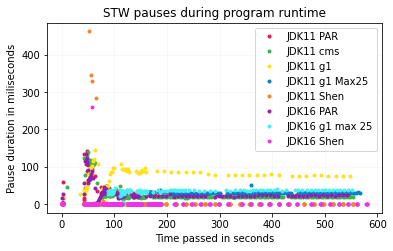

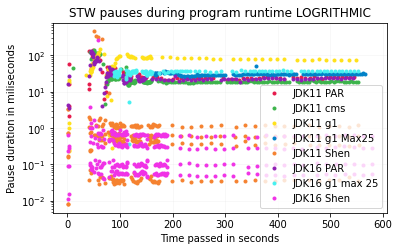

In [54]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.
def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False 

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes, 
                    filter_by = pauses_only,
                    labels=labels)
# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)

############################################################################################################
# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)



## Pauses by name during runtime

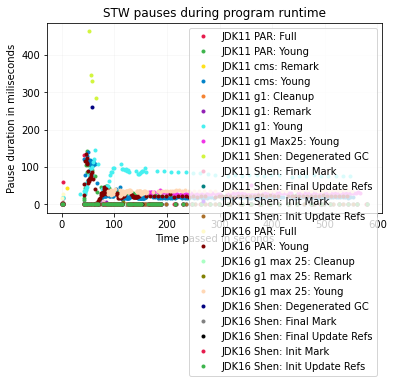

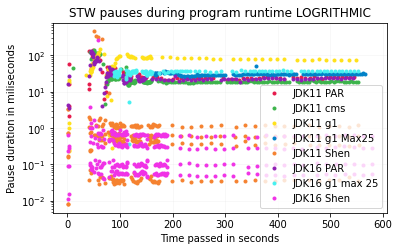

In [55]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.

def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False 

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes,
                    filter_by = pauses_only, 
                    labels=labels, 
                    group_by = "EventName")

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)
############################################################################################################
# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)



## Concurrent durations during runtime

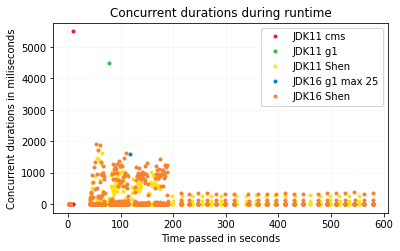

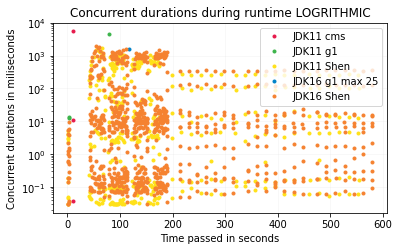

In [56]:
from plotting import plot_scatter

# Linear graph
def concurrent_only(row):
    if "EventType" in row:
        if row["EventType"] == "Concurrent":
            return True
    return False

plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)

# Logarithmic graph
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
plot.set_yscale("log")
_ = plot.set_title("Concurrent durations during runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)


## Time spent in STW vs. Concurrent

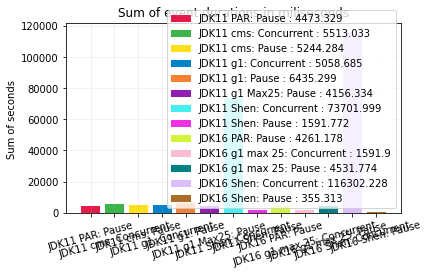

In [57]:
from plotting import plot_bar_sum

log = False # Set to True to view log bar graph as well
def duration_present(row):
    if "Duration_miliseconds" in row:
        if row["Duration_miliseconds"]:
            return True
    return False
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = plot.set_title("Sum of event durations in miliseconds")
_ = plot.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 15)
plot.grid(alpha = 0.2)
if log:
    plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
    _ = plot.set_title("Sum of event durations in miliseconds, LOGARITHMIC")
    _ = plot.set_ylabel("Sum of seconds ")
    plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
    plot.grid(alpha = 0.2)
    _ = plt.xticks(rotation = 15)



## Comparing Trends within the data

In [58]:
from plotting import plot_trends


def pauses_only(row):
       if "EventType" in row:
              if row["EventType"] == "Pause":
                     return True
       return False


print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels,
       throughput=True)
print("\n")

print("\t\t\tPauses by name during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       group_by = "EventName",
       filter_by = pauses_only,
       labels= labels)


			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
-----------------------------------------------------------------------------------------------------------------
JDK11 PAR       |  126.0000     |  142.3160     | 4473.3290     |   35.5026     |   26.1313     |   99.1800     % 
JDK11 cms       |  178.0000     |  139.9610     | 5244.2840     |   29.4623     |   28.1834     |   99.0500     % 
JDK11 g1        |   95.0000     |  145.4760     | 6435.2990     |   67.7400     |   30.3833     |   94.7100     % 
JDK11 g1 Max25  |  136.0000     |   51.2080     | 4156.3340     |   30.5613     |    2.5407     |   98.0400     % 
JDK11 Shen      |  281.0000     |  462.8690     | 1591.7720     |    5.6647     |   42.7428     |   99.7100     % 
JDK16 PAR       |  130.0000     |  133.5780     | 4261.17

## Percentiles of event durations

In [59]:
from plotting import plot_percentiles

def pauses_only(row):
       if "EventType" in row:
              if row["EventType"] == "Pause":
                     return True
       return False

print("\t\t\tPauses during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels)

print("\n\n")

print("\t\t\tPauses during runtime by name\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= pauses_only,
       labels= labels)
       

			Pauses during runtime
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | JDK11 PAR
B | JDK11 cms
C | JDK11 g1
D | JDK11 g1 Max25
E | JDK11 Shen
F | JDK16 PAR
G | JDK16 g1 max 25
H | JDK16 Shen
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%       | 99.9%     | 99.99%    | 
------------------------------------------------------------------------------------------------
A   |   24.7390 |   35.1915 |   79.9320 |  101.5342 |  128.7265 |  141.1636 |  142.2008 | 
B   |   18.9335 |   22.6820 |   50.4192 |  112.0748 |  124.2307 |  138.2568 |  139.7906 | 
C   |   77.8100 |   87.2555 |   95.5086 |  103.1858 |  122.5973 |  143.1881 |  145.2472 | 
D   |   30.5905 |   31.2825 |   32.6015 |   33.3780 |   36.6247 |   49.3724 |   51.0244 | 
E   |    0.5740 |    1.0450 |    1.2000 |    1.3390 |  292.5688 |  429.9558 |  4

## Mean durations in miliseconds, pauses

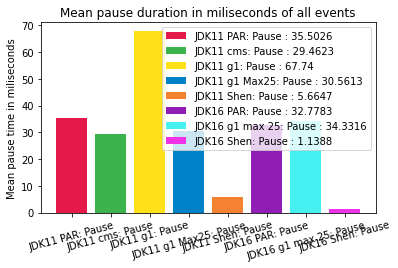

In [60]:

from plotting import plot_bar_avg

def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False 


graph = plot_bar_avg(gc_event_dataframes, group_by = "EventType", filter_by = pauses_only, labels = labels)
_ = graph.set_title("Mean pause duration in miliseconds of all events")
_ = graph.set_ylabel("Mean pause time in miliseconds")
_ = plt.xticks(rotation = 15)

## Heap allocation used before & after GC

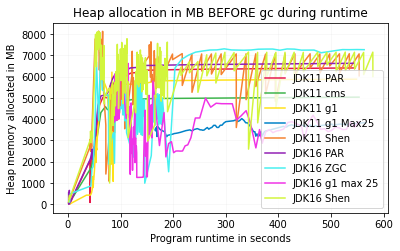

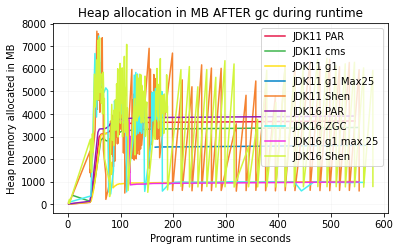

In [61]:
from plotting import plot_line

for df in gc_event_dataframes:
    if "TimeFromStart_seconds" in df:
        df.sort_values(by="TimeFromStart_seconds", axis=0,inplace=True)

def heap_before_gc(row):
    if "HeapBeforeGC" in row:
        if row["HeapBeforeGC"]:
            return True
    return False

plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = heap_before_gc, # Confirm that this column has data for every row
            labels = labels,
            column = "HeapBeforeGC")

_ = plot.set_title("Heap allocation in MB BEFORE gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = heap_before_gc,
            labels = labels,
            column = "HeapAfterGC" )
            #column_timing="DateTime")

_ = plot.set_title("Heap allocation in MB AFTER gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")

handles, labels = plot.get_legend_handles_labels()
plot.grid(alpha = 0.1)

## MB reclaimed during GC during runtime

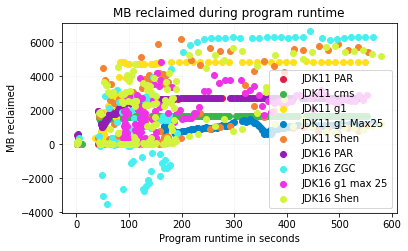

In [62]:
from plotting import plot_reclaimed_bytes

def gc_values_present(row):
    if "HeapBeforeGC" in row and "HeapAfterGC":
        if row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None:
            return True
    return False

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
_ = plot.set_title("MB reclaimed during program runtime")
_ = plot.set_ylabel("MB reclaimed")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## Heatmaps for each log

JDK11 PAR Warning: At least one value lies outside of the provided time range. Max value outside range: 545.806
JDK11 PAR Warning: At least one value lies outside the provided range for latency. Max value outside range: 142.316
JDK11 cms Warning: At least one value lies outside of the provided time range. Max value outside range: 560.391
JDK11 cms Warning: At least one value lies outside the provided range for latency. Max value outside range: 5501.907
JDK11 g1 Warning: At least one value lies outside of the provided time range. Max value outside range: 561.506
JDK11 g1 Warning: At least one value lies outside the provided range for latency. Max value outside range: 4474.405
JDK11 g1 Max25 Warning: At least one value lies outside of the provided time range. Max value outside range: 571.309
JDK11 g1 Max25 Warning: At least one value lies outside the provided range for latency. Max value outside range: 51.208
JDK11 Shen Warning: At least one value lies outside of the provided time range.

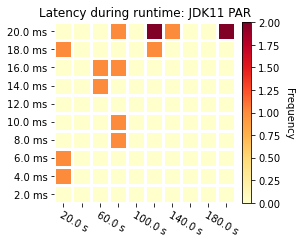

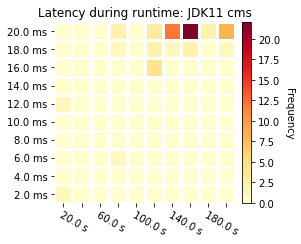

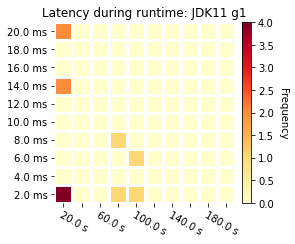

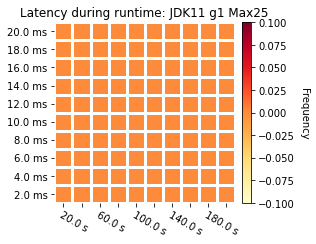

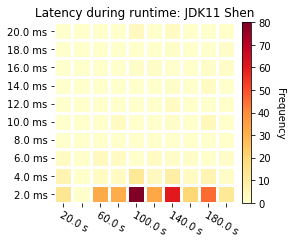

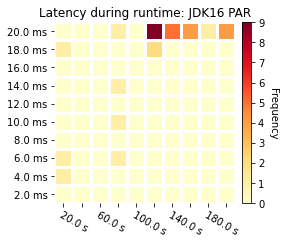

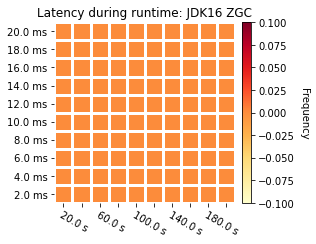

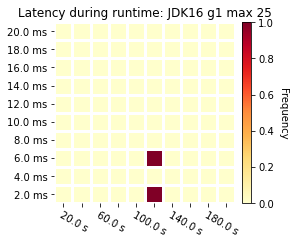

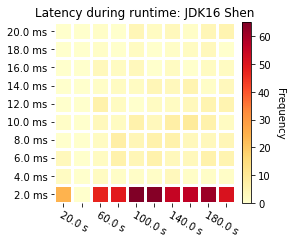

In [63]:
plt.rcParams["figure.figsize"] = [6, 3.5]
from src.graphing.heatmap import plot_heatmap, get_heatmap_data

for label, gc_event_dataframe in zip(labels, gc_event_dataframes):
    heatmap, dimensions = get_heatmap_data(gc_event_dataframe, 10,10, 20,2, label, True)     # Set the last value to FALSE to get warnings 
    if heatmap.size != 0 and dimensions:
        graph = plot_heatmap(heatmap, dimensions, False) # Set the last value to TRUE to see labels of frequency
        graph.set_title("Latency during runtime: " +  label)
        


## Frequency of pauses histogram

Text(0.5, 1.0, 'Pause frequencies during full runtime')

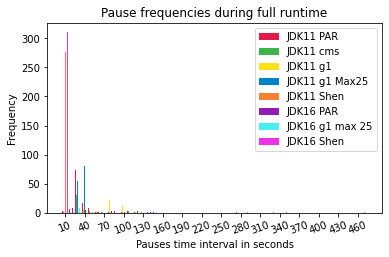

In [64]:
from plotting2 import plot_frequency_intervals

def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False

# All intervals are in seconds
plot = plot_frequency_intervals(gc_event_dataframes,
                         filter_by = pauses_only,
                         interval_duration= 10,                          
                         labels = labels)
                         
_ = plt.xticks(rotation = 20)
plot.set_xlabel("Pauses time interval in seconds")
plot.set_ylabel("Frequency")
plot.set_title("Pause frequencies during full runtime")


Percentiles plotted:  [99.9, 90, 50]


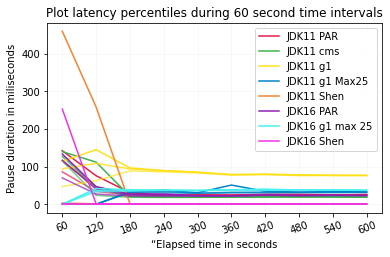

In [65]:
from plotting2 import plot_percentile_intervals
interval_duration = 60
percentiles = [99.9, 90, 50]
plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = pauses_only,
                                interval_duration = interval_duration ,
                                labels = labels,
                                percentiles = percentiles )
plot.set_ylabel("Pause duration in miliseconds")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Plot latency percentiles during "+ str(interval_duration) + " second time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)
print("Percentiles plotted: ", percentiles)

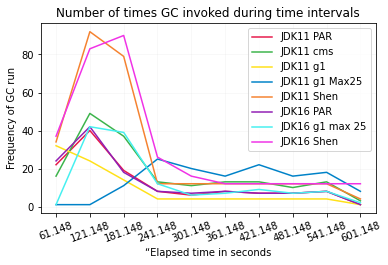

In [66]:
from plotting2 import plot_frequency_of_gc_intervals

plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = pauses_only, 
                                      interval_duration = 60 , 
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Number of times GC invoked during time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

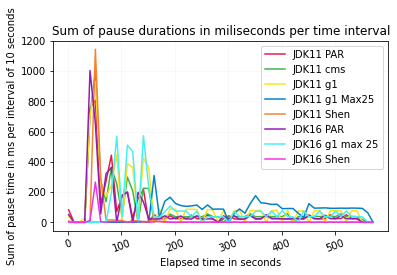

In [67]:
from plotting2 import plot_sum_pause_intervals

interval_duration = 10
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = pauses_only,
                                interval_duration = interval_duration, 
                                labels = labels)
_ = plot.set_title("Sum of pause durations in miliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

## Here is an example using external data plotted.

In [ ]:
##
#
#
#
#
##
#
#
#
#
##
#
#
#
#
#
#
#
#
#
#